In [1]:
from deap import gp, creator, base, tools
import operator, random, math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
def evolution(population, crxpr, nElit, ngen, evalFunction, x, y):
    HallOfFame=[]
    
    for j in range(ngen):
        
        for ind in population: ind.fitness.values = evalFunction(ind, x, y)
        HallOfFame.extend(tools.selBest(population, 1, fit_attr='fitness'))
        new_population = []
        if(nElit > 0):
            elits = tools.selBest(population, nElit, fit_attr='fitness')
            elits = [toolbox.clone(ind) for ind in elits]
            elits = toolbox.clone(elits)
            next_gen_population = len(population) - nElit
            new_population.extend(elits)
        else:
           next_gen_population = len(population) 
        population_to_cross = round((next_gen_population*crxpr)/2) # each reproduction provides two children
        population_to_mut = round((next_gen_population - population_to_cross*2)/2)

        for i in range(0, population_to_cross):
            parents = tools.selTournament(population, 2, 4, fit_attr='fitness')
            parent1, parent2 = [toolbox.clone(parent) for parent in parents]
            #children = list(gp.cxOnePoint(parent1, parent2))
            children = list(toolbox.cross(parent1, parent2))
            new_population.extend(children)

        for i in range(0, population_to_mut):
            mutant = tools.selTournament(population, 1, 4, fit_attr='fitness')
            mutant = toolbox.clone(mutant)
            #ind = gp.mutUniform(mutant[0], toolbox.expr, pset)
            ind = toolbox.mutate(mutant[0])
            new_population.append(ind[0])
        
        population = new_population
    return HallOfFame

In [3]:
def avg_migration_evolution(islands, crxpr, migpr, nElit, ngen, evalFunction, x, y):
    HallOfFame=[]
    for i in range(len(islands)):
        HallOfFame.append([])
    
    for j in range(ngen):
        islands_average = []
        new_islands = []
        
        for ind in islands[0]: ind.fitness.values = evalFunction(ind, x, y)
        for ind in islands[1]: ind.fitness.values = evalFunction(ind, x, y)
        for ind in islands[2]: ind.fitness.values = evalFunction(ind, x, y)
        
        average=0
        pop_len = len(islands[0])
        for ind in islands[0]: average = average + (ind.fitness.values[0]/pop_len)
        islands_average.append(average)
        average=0
        pop_len = len(islands[1])
        for ind in islands[1]: average = average + (ind.fitness.values[0]/pop_len)
        islands_average.append(average)
        average=0
        pop_len = len(islands[2])
        for ind in islands[2]: average = average + (ind.fitness.values[0]/pop_len)
        islands_average.append(average)
        
        max_avg_index = islands_average.index(max(islands_average))
        min_avg_index = islands_average.index(min(islands_average))
        
        for island_index, population in enumerate(islands):
            new_population = []
            next_gen_population = len(population)
                
            HallOfFame[island_index].extend(tools.selBest(population, 1, fit_attr='fitness'))
            
            if(island_index == max_avg_index):
                Number_of_immigrants = round(len(islands[min_avg_index])*migpr)
                immigrants = tools.selRandom(islands[min_avg_index], Number_of_immigrants)
                immigrants = [toolbox.clone(ind) for ind in immigrants]
                immigrants = toolbox.clone(immigrants)
                next_gen_population = next_gen_population - Number_of_immigrants
                new_population.extend(immigrants)
            elif(island_index == min_avg_index):
                Number_of_immigrants = round(len(islands[max_avg_index])*migpr)
                immigrants = tools.selRandom(islands[max_avg_index], Number_of_immigrants)
                immigrants = [toolbox.clone(ind) for ind in immigrants]
                immigrants = toolbox.clone(immigrants)
                next_gen_population = next_gen_population - Number_of_immigrants
                new_population.extend(immigrants)
                
            
            if(nElit > 0):
                elits = tools.selBest(population, nElit, fit_attr='fitness')
                elits = [toolbox.clone(ind) for ind in elits]
                elits = toolbox.clone(elits)
                next_gen_population = next_gen_population - nElit
                new_population.extend(elits)
            else:
               next_gen_population = len(population) 
            population_to_cross = round((next_gen_population*crxpr)/2) # each reproduction provides two children
            population_to_mut = round((next_gen_population - population_to_cross*2)/2)

            for i in range(0, population_to_cross):
                parents = tools.selTournament(population, 2, 4, fit_attr='fitness')
                parent1, parent2 = [toolbox.clone(parent) for parent in parents]
                #children = list(gp.cxOnePoint(parent1, parent2))
                children = list(toolbox.cross(parent1, parent2))
                new_population.extend(children)

            for i in range(0, population_to_mut):
                mutant = tools.selTournament(population, 1, 4, fit_attr='fitness')
                mutant = toolbox.clone(mutant)
                #ind = gp.mutUniform(mutant[0], toolbox.expr, pset)
                ind = toolbox.mutate(mutant[0])
                new_population.append(ind[0])
                
            new_islands.append(new_population)
            
        islands = new_islands
            
    return HallOfFame

In [4]:
def random_migration_evolution(islands, crxpr, migpr, nElit, ngen, evalFunction, x, y):
    HallOfFame=[]
    for i in range(len(islands)):
        HallOfFame.append([])
    
    for j in range(ngen):
        islands_average = []
        new_islands = []
        
        for ind in islands[0]: ind.fitness.values = evalFunction(ind, x, y)
        for ind in islands[1]: ind.fitness.values = evalFunction(ind, x, y)
        for ind in islands[2]: ind.fitness.values = evalFunction(ind, x, y)
        
        for island_index, population in enumerate(islands):
            new_population = []
            next_gen_population = len(population)
                
            HallOfFame[island_index].extend(tools.selBest(population, 1, fit_attr='fitness'))
            
            islands_copy = islands.copy()
            islands_copy.remove(islands[island_index])
            island_to_emigrate = random.sample(islands_copy,1)
            Number_of_immigrants = round(len(island_to_emigrate)*migpr)
            immigrants = tools.selRandom(island_to_emigrate, Number_of_immigrants)
            immigrants = [toolbox.clone(ind) for ind in immigrants]
            immigrants = toolbox.clone(immigrants)
            next_gen_population = next_gen_population - Number_of_immigrants
            new_population.extend(immigrants)
            
            if(nElit > 0):
                elits = tools.selBest(population, nElit, fit_attr='fitness')
                elits = [toolbox.clone(ind) for ind in elits]
                elits = toolbox.clone(elits)
                next_gen_population = next_gen_population - nElit
                new_population.extend(elits)
            else:
                next_gen_population = len(population) 
                population_to_cross = round((next_gen_population*crxpr)/2) # each reproduction provides two children
                population_to_mut = round((next_gen_population - population_to_cross*2)/2)

            for i in range(0, population_to_cross):
                parents = tools.selTournament(population, 2, 4, fit_attr='fitness')
                parent1, parent2 = [toolbox.clone(parent) for parent in parents]
                #children = list(gp.cxOnePoint(parent1, parent2))
                children = list(toolbox.cross(parent1, parent2))
                new_population.extend(children)

            for i in range(0, population_to_mut):
                mutant = tools.selTournament(population, 1, 4, fit_attr='fitness')
                mutant = toolbox.clone(mutant)
                #ind = gp.mutUniform(mutant[0], toolbox.expr, pset)
                ind = toolbox.mutate(mutant[0])
                new_population.append(ind[0])
                
            new_islands.append(new_population)
            
        islands = new_islands
            
    return HallOfFame

In [5]:
def shuffle(train_set):
    train_set = train_set.sample(frac = 1).reset_index(drop=True)
    x = train_set.iloc[:, 1:]
    y = train_set.iloc[:, [0]]
    return x.astype(float), y

In [6]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [7]:
def evalSymbReg(individual, x, y):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    hit=0
    for record in range(len(x)):
        if(func(*list(x.iloc[record]))>= 0 and y.iloc[record,0]=="M"):
            hit=hit+1
        elif(func(*list(x.iloc[record]))< 0 and y.iloc[record,0]=="B"):
            hit=hit+1
    return hit,

# Importing and Cleaning Data

In [8]:
with open('wdbc.data') as f:
    records = f.readlines()
print(len(records))
for index, record in enumerate(records):
    records[index] = record[:-1].split(",")
records = pd.DataFrame(records)
records

569


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
1,842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902
2,84300903,M,19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,...,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,...,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
4,84358402,M,20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,...,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142,1479,0.111,0.1159,0.2439,0.1389,...,25.45,26.4,166.1,2027,0.141,0.2113,0.4107,0.2216,0.206,0.07115
565,926682,M,20.13,28.25,131.2,1261,0.0978,0.1034,0.144,0.09791,...,23.69,38.25,155,1731,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,...,18.98,34.12,126.7,1124,0.1139,0.3094,0.3403,0.1418,0.2218,0.0782
567,927241,M,20.6,29.33,140.1,1265,0.1178,0.277,0.3514,0.152,...,25.74,39.42,184.6,1821,0.165,0.8681,0.9387,0.265,0.4087,0.124


In [9]:
records = records.drop(0, axis=1)
records = records.drop(records.columns[11:21], axis=1)
records = records.sample(frac = 1).reset_index(drop=True)
records

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,B,15.27,12.91,98.17,725.5,0.08182,0.0623,0.05892,0.03157,0.1359,...,17.38,15.92,113.7,932.7,0.1222,0.2186,0.2962,0.1035,0.232,0.07474
1,B,13.34,15.86,86.49,520,0.1078,0.1535,0.1169,0.06987,0.1942,...,15.53,23.19,96.66,614.9,0.1536,0.4791,0.4858,0.1708,0.3527,0.1016
2,M,20.58,22.14,134.7,1290,0.0909,0.1348,0.164,0.09561,0.1765,...,23.24,27.84,158.3,1656,0.1178,0.292,0.3861,0.192,0.2909,0.05865
3,M,19.1,26.29,129.1,1132,0.1215,0.1791,0.1937,0.1469,0.1634,...,20.33,32.72,141.3,1298,0.1392,0.2817,0.2432,0.1841,0.2311,0.09203
4,B,10.91,12.35,69.14,363.7,0.08518,0.04721,0.01236,0.01369,0.1449,...,11.37,14.82,72.42,392.2,0.09312,0.07506,0.02884,0.03194,0.2143,0.06643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,14.58,21.53,97.41,644.8,0.1054,0.1868,0.1425,0.08783,0.2252,...,17.62,33.21,122.4,896.9,0.1525,0.6643,0.5539,0.2701,0.4264,0.1275
565,B,11.81,17.39,75.27,428.9,0.1007,0.05562,0.02353,0.01553,0.1718,...,12.57,26.48,79.57,489.5,0.1356,0.1,0.08803,0.04306,0.32,0.06576
566,B,14.02,15.66,89.59,606.5,0.07966,0.05581,0.02087,0.02652,0.1589,...,14.91,19.31,96.53,688.9,0.1034,0.1017,0.0626,0.08216,0.2136,0.0671
567,B,12.31,16.52,79.19,470.9,0.09172,0.06829,0.03372,0.02272,0.172,...,14.11,23.21,89.71,611.1,0.1176,0.1843,0.1703,0.0866,0.2618,0.07609


In [10]:
train_set, test_set = train_test_split(records, test_size=0.3)
train_set=train_set.reset_index(drop=True)
train_set

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,B,12.05,14.63,78.04,449.3,0.1031,0.09092,0.06592,0.02749,0.1675,...,13.76,20.7,89.88,582.6,0.1494,0.2156,0.305,0.06548,0.2747,0.08301
1,M,23.29,26.67,158.9,1685,0.1141,0.2084,0.3523,0.162,0.22,...,25.12,32.68,177,1986,0.1536,0.4167,0.7892,0.2733,0.3198,0.08762
2,B,12.18,20.52,77.22,458.7,0.08013,0.04038,0.02383,0.0177,0.1739,...,13.34,32.84,84.58,547.8,0.1123,0.08862,0.1145,0.07431,0.2694,0.06878
3,B,12.42,15.04,78.61,476.5,0.07926,0.03393,0.01053,0.01108,0.1546,...,13.2,20.37,83.85,543.4,0.1037,0.07776,0.06243,0.04052,0.2901,0.06783
4,B,13.9,16.62,88.97,599.4,0.06828,0.05319,0.02224,0.01339,0.1813,...,15.14,21.8,101.2,718.9,0.09384,0.2006,0.1384,0.06222,0.2679,0.07698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,B,10.94,18.59,70.39,370,0.1004,0.0746,0.04944,0.02932,0.1486,...,12.4,25.58,82.76,472.4,0.1363,0.1644,0.1412,0.07887,0.2251,0.07732
394,B,9.676,13.14,64.12,272.5,0.1255,0.2204,0.1188,0.07038,0.2057,...,10.6,18.04,69.47,328.1,0.2006,0.3663,0.2913,0.1075,0.2848,0.1364
395,M,14.71,21.59,95.55,656.9,0.1137,0.1365,0.1293,0.08123,0.2027,...,17.87,30.7,115.7,985.5,0.1368,0.429,0.3587,0.1834,0.3698,0.1094
396,B,14.8,17.66,95.88,674.8,0.09179,0.0889,0.04069,0.0226,0.1893,...,16.43,22.74,105.9,829.5,0.1226,0.1881,0.206,0.08308,0.36,0.07285


In [11]:
test_set =test_set.reset_index(drop=True)
test_set

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,B,12.19,13.29,79.08,455.8,0.1066,0.09509,0.02855,0.02882,0.188,...,13.34,17.81,91.38,545.2,0.1427,0.2585,0.09915,0.08187,0.3469,0.09241
1,B,13.49,22.3,86.91,561,0.08752,0.07698,0.04751,0.03384,0.1809,...,15.15,31.82,99,698.8,0.1162,0.1711,0.2282,0.1282,0.2871,0.06917
2,B,12.31,16.52,79.19,470.9,0.09172,0.06829,0.03372,0.02272,0.172,...,14.11,23.21,89.71,611.1,0.1176,0.1843,0.1703,0.0866,0.2618,0.07609
3,M,15.85,23.95,103.7,782.7,0.08401,0.1002,0.09938,0.05364,0.1847,...,16.84,27.66,112,876.5,0.1131,0.1924,0.2322,0.1119,0.2809,0.06287
4,B,13.51,18.89,88.1,558.1,0.1059,0.1147,0.0858,0.05381,0.1806,...,14.8,27.2,97.33,675.2,0.1428,0.257,0.3438,0.1453,0.2666,0.07686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,B,11.89,18.35,77.32,432.2,0.09363,0.1154,0.06636,0.03142,0.1967,...,13.25,27.1,86.2,531.2,0.1405,0.3046,0.2806,0.1138,0.3397,0.08365
167,B,11.41,10.82,73.34,403.3,0.09373,0.06685,0.03512,0.02623,0.1667,...,12.82,15.97,83.74,510.5,0.1548,0.239,0.2102,0.08958,0.3016,0.08523
168,M,15.32,17.27,103.2,713.3,0.1335,0.2284,0.2448,0.1242,0.2398,...,17.73,22.66,119.8,928.8,0.1765,0.4503,0.4429,0.2229,0.3258,0.1191
169,M,20.55,20.86,137.8,1308,0.1046,0.1739,0.2085,0.1322,0.2127,...,24.3,25.48,160.2,1809,0.1268,0.3135,0.4433,0.2148,0.3077,0.07569


In [12]:
inp = test_set.iloc[:, 1:]
inp = inp.astype(float)

In [13]:
actual = test_set.iloc[:, [0]]
actual

,1
0,B
1,B
2,B
3,M
4,B
...,...
166,B
167,B
168,M
169,M


# Premitives

In [14]:
pset = gp.PrimitiveSet("MAIN", 20)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

In [15]:
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("island", tools.initRepeat, list, toolbox.individual)

toolbox.register("cross", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.decorate("cross", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

# Running the Algorithm for 10 times

In [16]:
seeds=[125, 85, 318, 10, 57, 701, 26, 564, 912, 487]
HallOfFame=[]
HallOfFame_avrg=[]
HallOfFame_random=[]
for i in range(10):
    random.seed(seeds[i])
    x, y = shuffle(train_set)
    pop = toolbox.population(n=300)
    HallOfFame.append(evolution(pop, 0.9, 0, 100, evalSymbReg, x, y))
    DEME_SIZES = 100, 200, 300
    pop = [toolbox.island(n=i) for i in DEME_SIZES]
    HallOfFame_avrg.append(avg_migration_evolution(pop, 0.9, 0.4, 0, 100, evalSymbReg, x, y))
    HallOfFame_random.append(random_migration_evolution(pop, 0.9, 0.4, 0, 100, evalSymbReg, x, y))
    

KeyboardInterrupt: 

In [17]:
HallOfFame_copy=HallOfFame.copy()
HallOfFame_avrg_copy=HallOfFame_avrg.copy()
HallOfFame_random_copy=HallOfFame_random.copy()

# Selecting the best answer 

In [18]:
tmp=[]
for i ,run in enumerate(HallOfFame):
    tmp.extend(HallOfFame[i])

for i, run in enumerate(HallOfFame_avrg):
    for j, island in enumerate(run):
        tmp.extend(HallOfFame_avrg[i][j])

for i, run in enumerate(HallOfFame_random):
    for j, island in enumerate(run):
        tmp.extend(HallOfFame_random[i][j])
best = tools.selBest(tmp, 1, fit_attr='fitness')

In [19]:
for i ,run in enumerate(HallOfFame):
    for j ,gen in enumerate(run):
        HallOfFame_copy[i][j]= gen.fitness.values[0]

for i, run in enumerate(HallOfFame_avrg):
    for j, island in enumerate(run):
        for k, gen in enumerate(island):
            HallOfFame_avrg_copy [i][j][k] = gen.fitness.values[0]

for i, run in enumerate(HallOfFame_random):
    for j, island in enumerate(run):
        for k, gen in enumerate(island):
            HallOfFame_random_copy [i][j][k] = gen.fitness.values[0]

In [20]:
HallOfFame_10Run_avrg = np.mean(np.array(HallOfFame_copy), axis=0)
HallOfFame_avrg_10Run_avrg = np.mean(np.array(HallOfFame_avrg_copy), axis=0)
HallOfFame_random_10Run_avrg = np.mean(np.array(HallOfFame_random_copy), axis=0)

HallOfFame_10Run_max = np.max(np.array(HallOfFame_copy), axis=0)
HallOfFame_avrg_10Run_max = np.max(np.array(HallOfFame_avrg_copy), axis=0)
HallOfFame_random_10Run_max = np.max(np.array(HallOfFame_random_copy), axis=0)

In [41]:
print(HallOfFame_10Run_avrg)
print("\n")
print(HallOfFame_avrg_10Run_avrg)
print("\n")
print(HallOfFame_random_10Run_avrg)

[336.2 345.  356.4 356.9 360.5 360.8 360.8 361.6 361.6 361.8]


[[275.4 304.2 323.7 335.6 342.  342.  358.5 359.  359.3 360.2]
 [321.2 336.3 340.4 346.7 351.6 354.3 354.9 357.5 358.  358. ]
 [336.4 346.9 352.2 358.3 358.7 359.3 359.3 359.7 362.7 362.7]]


[[275.4 292.8 307.6 332.5 332.6 332.7 334.3 334.3 335.8 339.6]
 [321.2 336.2 345.5 346.  352.6 355.7 355.7 356.1 356.8 356.8]
 [336.4 345.8 353.5 359.6 361.2 361.7 361.7 361.7 362.6 363.7]]


# Illustration

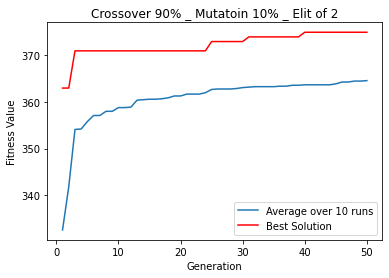

In [35]:
x = list(range(1, len(HallOfFame_10Run_avrg)+1))
y = HallOfFame_10Run_avrg
y_1 = HallOfFame_10Run_max
plt.plot(x, y)
plt.plot(x, y_1, color='r')
plt.title("Crossover 90% _ Mutatoin 10% _ Elit of 2")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend(["Average over 10 runs", "Best Solution"], loc ="lower right")

plt.savefig('Simple_1(90_10_2).jpg')
plt.show()

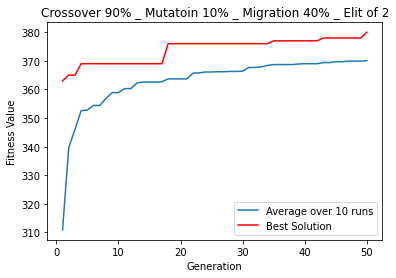

In [36]:
x = list(range(1, len(HallOfFame_avrg_10Run_avrg[0])+1))
y = HallOfFame_avrg_10Run_avrg[0]
y_1 = HallOfFame_avrg_10Run_max[0]
plt.plot(x, y)
plt.plot(x, y_1, color='r')
plt.title("Crossover 90% _ Mutatoin 10% _ Migration 40% _ Elit of 2")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend(["Average over 10 runs", "Best Solution"], loc ="lower right")

plt.savefig('Average_1(90_10_40_2).jpg')
plt.show()

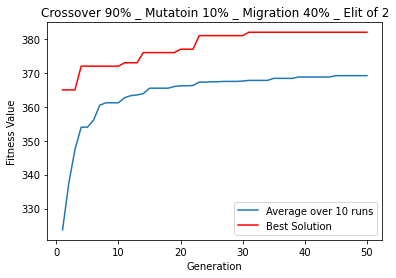

In [37]:
x = list(range(1, len(HallOfFame_random_10Run_avrg[2])+1))
y = HallOfFame_random_10Run_avrg[2]
y_1 = HallOfFame_random_10Run_max[2]
plt.plot(x, y)
plt.plot(x, y_1, color='r')
plt.title("Crossover 90% _ Mutatoin 10% _ Migration 40% _ Elit of 2")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend(["Average over 10 runs", "Best Solution"], loc ="lower right")

plt.savefig('Random_1(90_10_40_2).jpg')
plt.show()

# Testing

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
func = toolbox.compile(expr=best[0])
predict_value = [func(*list(inp.iloc[record])) for record in range(len(test_set))]
for i, value in enumerate(predict_value):
    if(value>= 0):
        predict_value[i] = "M"
    else:
        predict_value[i] = "B"

In [38]:
df=pd.DataFrame(confusion_matrix(actual, predict_value, labels=["M", "B"]))
df=df.rename(columns={0: "M", 1: "B"})
df = df.rename(index={0: "M", 1: "B"})
df

,M,B
M,60,5
B,2,104


In [40]:
import dataframe_image as dfi
dfi.export(df,"mytable.png")

[0421/131110.402233:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0421/131110.802914:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0421/131113.406639:INFO:headless_shell.cc(659)] Written to file /tmp/tmp4gbc9aq7/temp.png.


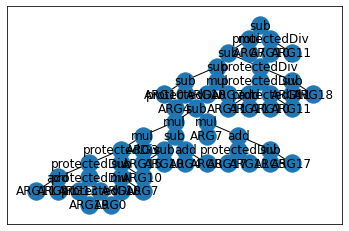

In [41]:
tree = gp.PrimitiveTree(best[0])
nodes, edges, labels = gp.graph(tree)

import networkx as nx
import pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

In [42]:
import pygraphviz as pgv

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree_1.png")